In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.use('Agg')

In [2]:
import xarray as xr
import netCDF4
import glob
import numpy as np
import copy 
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from pyproj import Proj
import datetime
import pandas as pd
import geopy.distance
import s3fs
import netCDF4 as nc
import io

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import colors
from scipy import interpolate
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
%matplotlib inline

In [3]:
cases=34

time_LT_5mins=np.arange( (18.-8.)*60./5.+1 )*5./60.+8. # 5 mins
half_time_bin_5mins=(time_LT_5mins[1]-time_LT_5mins[0])/2.

folder_name=np.array(['0.0_1.0','2.0_1.0','2.0_1.0'])
correction_name=np.array(['No_Correction','No_Correction','Corrected'])

bias_cogs_center=np.array([ 0.06658869,  0.0195071 , -0.02866472, -0.01596877, -0.03005094,-0.01416801, 0,0,0,0])
bias_goes_pixel=np.array([ 0.09027758,  0.01426901, -0.03432028, -0.0193933 , -0.05350255,-0.03456194, 0,0,0,0])


In [4]:
time_LT=np.arange( (18.-8.)*60./60.+1 )*60./60.+8. # 60 mins
half_time_bin=(time_LT[1]-time_LT[0])/2.
print(half_time_bin)

# with bin
CF_bin=np.arange(10)*0.1+0.05
CF_bin_width=CF_bin[1]-CF_bin[0]


0.5


#### Step by Step ####

In [5]:
def calculate_mean_bias(y_true, y_pred):
    """
    Calculate the mean bias between the true and predicted values.
    
    Parameters:
    y_true (array-like): Array of true values.
    y_pred (array-like): Array of predicted values.
    
    Returns:
    float: The mean bias value.
    """
    bias = np.nanmean(y_pred - y_true)
    return bias

def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE) between the true and predicted values.
    
    Parameters:
    y_true (array-like): Array of true values.
    y_pred (array-like): Array of predicted values.
    
    Returns:
    float: The RMSE value.
    """
    squared_errors = (y_true - y_pred) ** 2
    mean_squared_error = np.nanmean(squared_errors)
    rmse = np.sqrt(mean_squared_error)
    return rmse


def calculate_mae(y_true, y_pred):

    mae = np.nanmean(np.abs(y_pred - y_true))
    
    return mae



In [6]:
sample_045=np.empty((len(folder_name),len(CF_bin)))
bias_1km_045=np.empty((len(folder_name),len(CF_bin)))
bias_std_error_1km_045=np.empty((len(folder_name),len(CF_bin)))

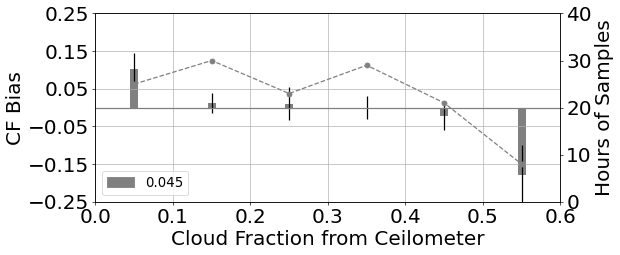

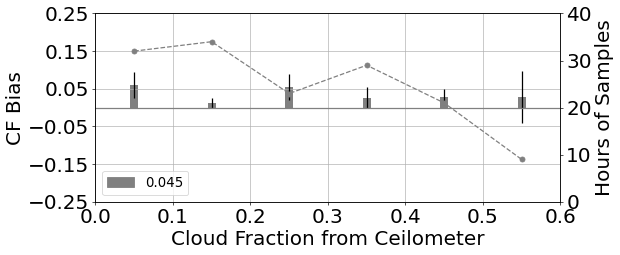

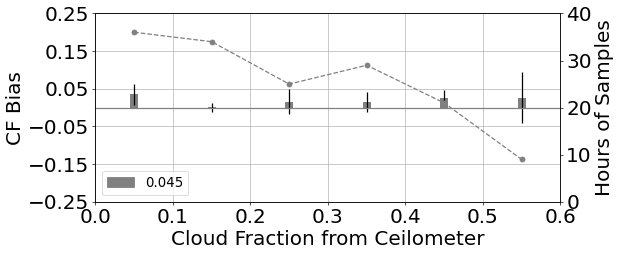

In [7]:
for mmm in np.arange(len(folder_name)):
    
    if mmm==0:
        corrections=np.arange(10)*0.0
    if mmm==1: 
        corrections=np.arange(10)*0.0
    if mmm==2:
        corrections=copy.deepcopy(bias_goes_pixel)   

    
    GOES_dir=f'./Data/'
    
    GOES_filein=f'{GOES_dir}*{folder_name[mmm]}*.nc'
    GOES_output_list=glob.glob(GOES_filein)
    GOES_data = xr.open_dataset(GOES_output_list[0])
    
    time_5mins=GOES_data.time_5mins.values
    GOES_CF_045_5mins=GOES_data.GOES_CF_045_5mins.values 
    Ceil_CF_5mins=GOES_data.Ceil_CF_5mins.values
    
    

    GOES_CF_045_5mins_correct=np.empty_like(GOES_CF_045_5mins)*np.nan


    #####
    for i in np.arange(len(CF_bin)):

        loc_bins=np.where( (Ceil_CF_5mins>(CF_bin[i]-CF_bin_width/2.) ) & (Ceil_CF_5mins<=(CF_bin[i]+CF_bin_width/2.) )  )   
        
        if loc_bins[0].shape[0]>0:

            GOES_CF_045_5mins_correct[loc_bins]=GOES_CF_045_5mins[loc_bins]-corrections[i]    
   
    GOES_CF_045_5mins_correct[GOES_CF_045_5mins_correct<0]=0     
    GOES_CF_045_5mins_correct[GOES_CF_045_5mins_correct>1]=1         
            
    ####Do the average###
    GOES_hourly_CF_045=np.zeros( (cases,len(time_LT)) )*np.nan
    Ceil_hourly_CF=np.zeros( (cases,len(time_LT)) )*np.nan    

    
    for j in np.arange(cases):

        for i in np.arange(len(time_LT)):

            loc=np.where(  (time_5mins>= (time_LT[i]-half_time_bin) ) & (time_5mins< (time_LT[i]+half_time_bin)  ) )

            if loc[0].shape[0]>0:
                GOES_hourly_CF_045[j,i]=np.nanmean(GOES_CF_045_5mins_correct[j,loc])                
                Ceil_hourly_CF[j,i]=np.nanmean(Ceil_CF_5mins[j,loc])                


                
    ###Read in Cloud Base###
    CB_mean_1hour=GOES_data.CB_mean_1hour.values

    ####Calculate the Bias###For Plot###
    for i in np.arange(len(CF_bin)):



        loc_bin_045=np.where( (GOES_hourly_CF_045>0) & (Ceil_hourly_CF > 0)  & (CB_mean_1hour>0) & (CB_mean_1hour<3) & \
                     ( Ceil_hourly_CF> (CF_bin[i]-CF_bin_width/2.)  ) & (Ceil_hourly_CF<= (CF_bin[i]+CF_bin_width/2.) ) )

        
        ###Sample Number###
        sample_045[mmm,i]=loc_bin_045[0].shape[0]
        bias_1km_045[mmm,i]=np.nanmean( GOES_hourly_CF_045[loc_bin_045])-np.nanmean(Ceil_hourly_CF[loc_bin_045] )
        b=GOES_hourly_CF_045[loc_bin_045]-Ceil_hourly_CF[loc_bin_045]
        bias_std_error_1km_045[mmm,i]=np.nanstd(b)/np.sqrt(len(b))
    
    if mmm>=0 : 
    
        ###Generate Plot###
        mpl.rcParams['font.size'] = 24
        mpl.rcParams['font.weight'] = 'regular'
        mpl.rcParams['font.family'] = 'DejaVu Sans'
        fig = plt.figure(figsize=[10,4], dpi=60)

        gs = gridspec.GridSpec(1, 20)
        gs.update(wspace=0.5, hspace=0.3, top=0.91)

        ax6 = plt.subplot(gs[0,0:20])


        ax6.bar(CF_bin,bias_1km_045[mmm,:],yerr=bias_std_error_1km_045[mmm,:],color='grey',width=0.01, align='center')
        colors = {f'0.045':'grey'}   

        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]


        ax6.set_xlabel('Cloud Fraction from Ceilometer')
        ax6.set_ylabel('CF Bias')
        
        ax6.grid()
        ax6.axhline(y=0, color='grey', linestyle='-')

        ax6.legend(handles, labels,fontsize=16,loc='lower left')
        ax6.set_ylim(-0.25,0.25)
        ax6.set_yticks(np.arange(-0.25,0.35, 0.1))
        ax6.set_xlim(0.,0.6)
        
        
        # Create a secondary y-axis for sample numbers
        ax6_right = ax6.twinx()
        ax6_right.plot(CF_bin[:6], sample_045[mmm, :6], '--',marker='o', color='grey')
        ax6_right.set_ylim(0, 40)
        ax6_right.set_ylabel('Hours of Samples')
        
        ax6_right.grid(False) 

        #fig.savefig(f'./{folder_name[mmm]}_{correction_name[mmm]}_1hour.png', dpi=300, bbox_inches='tight') 



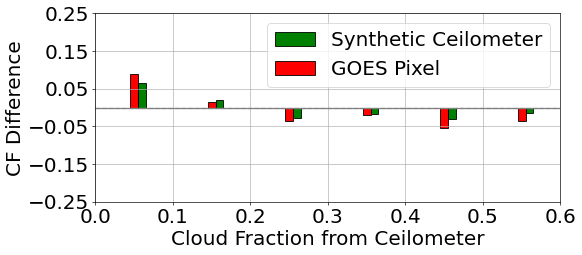

In [8]:

mpl.rcParams['font.size'] = 24
mpl.rcParams['font.weight'] = 'regular'
mpl.rcParams['font.family'] = 'DejaVu Sans'
fig = plt.figure(figsize=[10,4], dpi=60)

gs = gridspec.GridSpec(1, 20)
gs.update(wspace=0.5, hspace=0.3, top=0.91)

ax6 = plt.subplot(gs[0,0:20])


        
ax6.bar(CF_bin+0.01,bias_cogs_center,color='green',width=0.01,label='Synthetic Ceilometer',edgecolor='black')
ax6.bar(CF_bin,bias_goes_pixel,color='red',width=0.01,label='GOES Pixel',edgecolor='black')


ax6.set_xlabel('Cloud Fraction from Ceilometer')
ax6.set_ylabel('CF Difference')

ax6.axhline(y=0, color='grey', linestyle='--')

ax6.legend()
ax6.set_ylim(-0.25,0.25)
ax6.set_yticks(np.arange(-0.25,0.35, 0.1))
ax6.set_xlim(0.,0.6)

ax6.grid()
ax6.axhline(y=0, color='grey', linestyle='-')

#fig.savefig(f'./Figure_Correction.png', dpi=300, bbox_inches='tight') 


